# The representation of women in the movie industry around the world

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import pycountry
import pycountry_convert as pc
import swifter

from functools import lru_cache
from scipy import stats
from itertools import islice
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression

from helpers_corenlp import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/ada/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from functions import percent_missing_strdict

**Table of content**

1. [Data pre-processing](#Data-pre-processing)
    - [Part 1: CMU Movie Summary](#part1)
    - [Part 2: CoreNLP parsed movie summaries dataset](#part1.2)
    - [Part 3: IMDB Datasets](#part1.3)
    - [Part 4: Oscars Dataset](#part1.4)
    - [Part 5: Bechdel Dataset](#part1.5)
2. [Data Analysis](#Data-analysis)
    - [Part 1: Quantitative analysis of gender inequalities in movies](#part2.1)
    - [Part 2: Qualititative analysis of gender representation in movies](#part2.2)
    - [Part 3: Analysis of the reception of movies by the public](#part2.3)
    - [Part 4:  Analysis by geographical production region](#part2.4)

## STEP 1: DATA PRE-PROCESSING <a class="anchor" id="Data-pre-processing"></a>

---

In [44]:
current_directory = os.getcwd()

DATA_PATH = os.path.join(current_directory, 'MovieSummaries')
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHARACTER_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
CHARACTER_TYPE_PATH = os.path.join(DATA_PATH, 'tvtropes.clusters.txt')
RATINGS_PATH = os.path.join(current_directory, 'Ratings_PreProcessed.tsv')

CORE_NLP_PATH = os.path.join(current_directory, 'corenlp')
CORE_NLP_GZ = CORE_NLP_PATH + "/corenlp_plot_summaries"
CORE_NLP_XML = CORE_NLP_PATH + "/corenlp_plot_summaries_xml"

IMDB_PATH = os.path.join(current_directory, 'IMDB')
IMDB_BASICS_PATH = IMDB_PATH + "/title.basics.tsv"
IMDB_RATINGS_PATH = IMDB_PATH + "/title.ratings.tsv"

BECHDEL_PATH = os.path.join(current_directory, 'bechdel_movies_2023_FEB.csv')

AWARDS_PATH = os.path.join(current_directory, 'the_oscar_award.csv')

## PART 1: CMU Movie Summary <a id="part1"></a>

We will use the files movies.metadata.tsv and characters.metadata.tsv .

In [4]:
# Load the datasets
headers_movies = ['WikiMovieID', 
                  'FreebaseMovieID', 
                  'MovieName', 
                  'ReleaseDate', 
                  'BORevenue', 
                  'Runtime',
                  'Languages', 
                  'Countries', 
                  'MovieGenre']

headers_characters = ['WikiMovieID', 
                      'FreebaseMovieID', 
                      'ReleaseDate', 
                      'CharacterName', 
                      'DoB', 
                      'Gender', 
                      'Height', 
                      'Ethnicity', 
                      'ActorName', 
                      'Age', 
                      'FreebaseActorMapID', 
                      'FreebaseCharacterID', 
                      'FreebaseActorID']

movies = pd.read_csv(MOVIE_PATH, sep='\t', names=headers_movies)
characters = pd.read_csv(CHARACTER_PATH, sep='\t', names=headers_characters)

In [5]:
nb_movie = movies['WikiMovieID'].nunique()
print(f'The movie dataset contains {nb_movie} movies')
movies.sample(3)

The movie dataset contains 81741 movies


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre
55216,551619,/m/0bg1bn,Gospel of John,2003,NaN,180.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada"", ""/m/07ssc"": ""United Ki...","{""/m/04p5fxn"": ""Christian film"", ""/m/06l3bl"": ..."
21459,26652800,/m/0bh8wt9,Katha Parayum Theruvoram,2009,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}"
9468,4429283,/m/0c1w4s,Hondo,1953-11-27,4100000.0,83.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":..."


In [6]:
nb_char = len(characters.index)
print(f'The characters dataset contains {nb_char} characters')
print('Percentage of missing entries in the character.metadata dataset:\n', 100*characters[['FreebaseMovieID', 'ReleaseDate', 'CharacterName',
                                                                                   'DoB', 'Gender', 'Height', 'Ethnicity',
                                                                                   'ActorName', 'Age', 'FreebaseCharacterID',
                                                                                   'FreebaseActorID']].isna().sum() / len(characters))
characters.sample(3)

The characters dataset contains 450669 characters
Percentage of missing entries in the character.metadata dataset:
 FreebaseMovieID         0.000000
ReleaseDate             2.217814
CharacterName          57.220488
DoB                    23.552763
Gender                 10.120288
Height                 65.645740
Ethnicity              76.466542
ActorName               0.272484
Age                    35.084064
FreebaseCharacterID    57.218269
FreebaseActorID         0.180842
dtype: float64


,WikiMovieID,FreebaseMovieID,ReleaseDate,CharacterName,DoB,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
137410,20959511,/m/05b38q1,2010,Skippy Pylon,1968-07-24,F,1.5,/m/0dbxy,Kristin Chenoweth,41.0,/m/03kykpv,/m/0gxnxcl,/m/047c9l
218173,27053354,/m/0bs6s4s,2010-09-22,Rabier,1989-09-23,M,NaN,NaN,Arthur Mazet,20.0,/m/0bv9r5n,/m/0bv9r7p,/m/0bv9r4v
255513,171550,/m/0170w2,1997-06-13,Ferris Dooley,1971-12-30,M,NaN,NaN,Dewey Weber,25.0,/m/0cc3522,/m/0cc3525,/m/0cc352d


##### Gender

Our project focuses on differences between gender representations in movies; thus we keep only movies & characters where we have information about the characters' gender.

In [7]:
from functions import convert_date

print('Percentage of missing gender entries in the character dataset:\n', 100*characters[['Gender']].isna().sum() / len(characters))
# Keep only the rows for which we have the gender of the actor/actress
characters = characters.loc[characters['Gender'].isin(['F', 'M'])].copy(deep=True)
print(f'The character dataset contains {len(characters.index)} characters after filtering on the characters gender')

Percentage of missing gender entries in the character dataset:
 Gender    10.120288
dtype: float64
The character dataset contains 405060 characters after filtering on the characters gender


##### Release date

In [8]:
# The movie 'Hunting Season' has an incorrect data: 1010 instead of 2010
characters['ReleaseDate'] = characters['ReleaseDate'].replace('1010-12-02', '2010-12-02')
movies['ReleaseDate'] = movies['ReleaseDate'].replace('1010-12-02', '2010-12-02')

# Convert the date in the column 'ReleaseDate' into datetime
characters_ReleaseDate_datatime = characters['ReleaseDate'].apply(convert_date)
movies_ReleaseDate_datatime = movies['ReleaseDate'].apply(convert_date)

# Add a column with the year of release only
characters['ReleaseYear'] = characters_ReleaseDate_datatime.dt.year.fillna(0).astype(int)
characters['ReleaseYear'] = characters['ReleaseYear'].astype('int64')
characters['ReleaseYear'].replace(0, np.nan, inplace=True)

movies['ReleaseYear'] = movies_ReleaseDate_datatime.dt.year.fillna(0).astype(int)
movies['ReleaseYear'] = movies['ReleaseYear'].astype('int64')
movies['ReleaseYear'].replace(0, np.nan, inplace=True)

In [9]:
characters.sample(2)

,WikiMovieID,FreebaseMovieID,ReleaseDate,CharacterName,DoB,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
426881,19991665,/m/04y7ksr,1955,NaN,1930-04-19,M,1.87,NaN,Dick Sargent,24.0,/m/0dglf80,NaN,/m/028kcd,1955.0
193751,18676748,/m/04gqrx6,1999,NaN,1942-09-28,M,1.86,NaN,Marshall Bell,56.0,/m/0cg10m_,NaN,/m/08hk3x,1999.0


In [10]:
movies.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear
26286,7768616,/m/0kvgvm,"Don Q, Son of Zorro",1925-06-15,NaN,111.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/03k9fj"": ""Adve...",1925.0
29058,25267846,/m/09gjhfh,BFF: Best Friends Forever,2009,NaN,102.0,"{""/m/07qv_"": ""Tagalog language"", ""/m/01jb8r"": ...","{""/m/05v8c"": ""Philippines""}","{""/m/01z4y"": ""Comedy"", ""/m/03q4nz"": ""World cin...",2009.0


##### Age

In [11]:
# Replace null or negative age values by NaN
characters['Age'] = characters['Age'].apply(lambda x: np.nan if x <= 0 else x)

#### Deal with dictionnaries

In [12]:
# Convert the str-like dictionaries to dictionaries
movies['Countries'] = movies['Countries'].apply(ast.literal_eval)
movies['MovieGenre'] = movies['MovieGenre'].apply(ast.literal_eval)
movies['Languages'] = movies['Languages'].apply(ast.literal_eval)

In [13]:
movies.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear
76703,30466346,/m/0g5pxky,Achan,NaN,NaN,NaN,{},{},{'/m/07s9rl0': 'Drama'},NaN
43783,12287985,/m/09rvk9z,Till Human Voices Wake Us,2002-09-12,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...","{'/m/01jfsb': 'Thriller', '/m/03q4nz': 'World ...",2002.0


##### Merge the characters & movies datasets

In [14]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu = movies.merge(characters, how='inner', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate', 'ReleaseYear'])
cmu = cmu.drop(['DoB', 'Height', 'Runtime'], axis=1).copy(deep=True)

print(f'The cmu dataset contains {len(cmu.index)} entries')
cmu.sample(2)

The cmu dataset contains 405060 entries


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
192194,31844786,/m/08q3qb4,The Great American Broadcast,1941-05-09,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/07s9rl0': 'Drama', '/m/0hj3msd': 'Adventu...",1941.0,NaN,M,/m/04dbw3,Cesar Romero,34.0,/m/0cg89d4,NaN,/m/022q4j
86988,13494664,/m/03c75wv,We'll Meet Again,1943-01-18,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/04t36': 'Musical'},1943.0,Sally,F,NaN,Lesley Osmond,21.0,/m/0jvq98f,/m/0jvq98j,/m/0gtt75b


In [15]:
print('Percentage of missing entries in the cmu dataset:\n', 100*cmu[['WikiMovieID', 'FreebaseMovieID', 'MovieName', 'ReleaseDate', 'BORevenue',
                                                                                 'ReleaseYear', 'CharacterName',
                                                                                  'Gender', 'Ethnicity',
                                                                                   'ActorName', 'Age', 'FreebaseCharacterID',
                                                                                   'FreebaseActorID', 'FreebaseActorMapID']].isna().sum() / len(cmu))

print('Languages', percent_missing_strdict(cmu['Languages'])) 
print('Countries', percent_missing_strdict(cmu['Countries']))
print('MovieGenre', percent_missing_strdict(cmu['MovieGenre']))                                                                                     

Percentage of missing entries in the cmu dataset:
 WikiMovieID             0.000000
FreebaseMovieID         0.000000
MovieName               0.000000
ReleaseDate             2.430751
BORevenue              76.733570
ReleaseYear             2.430751
CharacterName          54.213944
Gender                  0.000000
Ethnicity              73.828322
ActorName               0.002963
Age                    28.319508
FreebaseCharacterID    54.211969
FreebaseActorID         0.000000
FreebaseActorMapID      0.000000
dtype: float64
Languages 7.365575470300696
Countries 3.595022959561547
MovieGenre 0.9877549005085665


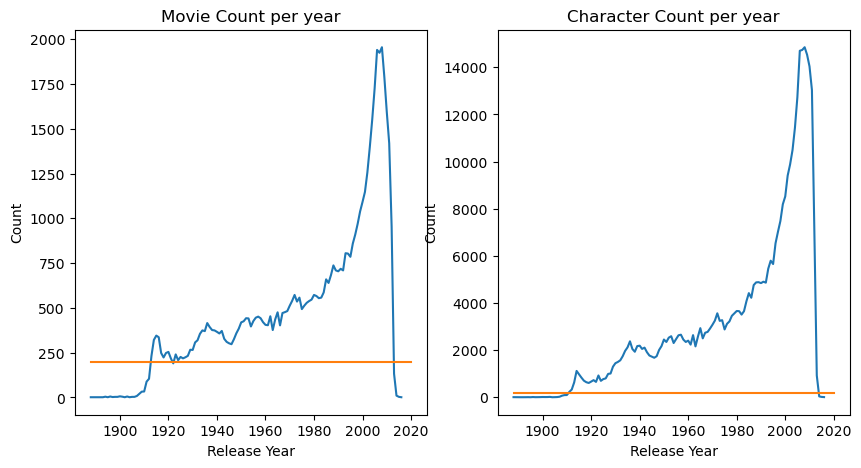

In [16]:
movie_count_per_year = cmu.groupby(['ReleaseYear']).agg({'WikiMovieID' : 'nunique'})
character_count_per_year = cmu.groupby(['ReleaseYear']).agg({'Gender': 'count'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize= (10,5))
ax1.plot(movie_count_per_year)
ax1.plot([1888, 2020], [200, 200])
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Count')
ax1.set_title('Movie Count per year')

ax2.plot(character_count_per_year)
ax2.plot([1888, 2020], [200, 200])
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Count')
ax2.set_title('Character Count per year')

plt.show()

In [17]:
# Keep only movies between 1925 and 2012 to have at least 200 movies per year and at least 100 characters per year.
cmu = cmu.loc[(movies['ReleaseYear'] >= 1925) & (cmu['ReleaseYear'] <= 2012)].copy(deep=True)
print(f'The cmu dataset contains {len(cmu.index)} entries after filtering to have at least 200 movies and 100 characters per year.')

The cmu dataset contains 68558 entries after filtering to have at least 200 movies and 100 characters per year.


### Add geographical data to our dataset

We will perform a geographical analysis; for this purpose, we will create specialized datasets.  

In [18]:
#Initial number of rows in the movies dataset
nb_row_countries = len(movies)

# Create a new dataset from movies where we remove the rows in the 'Countries' column that lack information about countries.
movies_geo = movies[movies['Countries'].apply(lambda x: len(x)!=0)].copy(deep=True)

num_rows_dropped = nb_row_countries-len(movies_geo)
percentage_rows_dropped = (num_rows_dropped / nb_row_countries) * 100
print(f'We dropped {num_rows_dropped} rows, corresponding to {percentage_rows_dropped:.2f}% of our original movies dataset.')

We dropped 8154 rows, corresponding to 9.98% of our original movies dataset.


In [19]:
# We convert the column type from dictionaries to a list of strings.
movies_geo['Countries'] = movies_geo['Countries'].apply(lambda x: [val for val in x.values()])

To facilitate the analysis, we will utilize the ISO databases available in the pycountry library for standardized country names.

In [20]:
from functions import bulkFindCountries

movies_geo['Countries'] = movies_geo['Countries'].swifter.apply(bulkFindCountries)

Pandas Apply: 100%|██████████| 73587/73587 [00:02<00:00, 28253.15it/s]


In [21]:
from functions import process_countries

length_before = len(movies_geo)

movies_geo['Countries'] = movies_geo['Countries'].apply(process_countries).copy(deep=True)
#Filter out NaN values
movies_geo = movies_geo.dropna(subset=['Countries']).copy(deep=True)

length_after = len(movies_geo)
print(f'By filtering out Nan values, we dropped {length_before-length_after} rows, corresponding to {((length_before-length_after)/length_before)*100:.2f}% of our dataset.')
print(f'The filtered dataset contains {length_after} movies.')

By filtering out Nan values, we dropped 1545 rows, corresponding to 2.10% of our dataset.
The filtered dataset contains 72042 movies.


We keep only the countries for which we have the alpha_2 code

In [22]:
# Then we can determine the continent using the alpha_2 code
movies_geo['Continent'] = movies_geo['Countries'].apply(lambda x: [pc.country_alpha2_to_continent_code(country) for country in x]).copy(deep=True)

In [23]:
# If a row contains multiple occurrences of the same continent, eliminate the duplicates within the list
movies_geo['Continent'] = movies_geo['Continent'].apply(lambda x: list(dict.fromkeys(x)) if isinstance(x, list) else x).copy(deep=True)

In [24]:
# Remove the rows for which we have more than one unique continent
length_before = len(movies_geo)

movies_geo = movies_geo[movies_geo['Continent'].apply(lambda x: len(x) <= 1)].copy(deep=True)

length_after = len(movies_geo)
print(f'{length_before-length_after} rows were dropped')

4649 rows were dropped


In [25]:
# Change the data type of the 'Continent' column from a list to a string since it now contains lists with only one element
movies_geo['Continent'] = movies_geo['Continent'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [26]:
# convert list in string
movies_geo['Countries'] = movies_geo['Countries'].apply(lambda x: x[0] if isinstance(x, list) else x)
movies_geo.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear,Continent
41747,34430482,/m/0h_cph8,God Bless America,2011-09-09,231319.0,100.0,{'/m/02h40lc': 'English Language'},US,"{'/m/05p553': 'Comedy film', '/m/07s9rl0': 'Dr...",2011.0,NA
78522,32177555,/m/0gwz18j,Sneeze Me Away,2010-03-01,NaN,NaN,{},KR,"{'/m/02hmvc': 'Short Film', '/m/03k9fj': 'Adve...",2010.0,AS


In [27]:
print(f'Our final dataset contains {len(movies_geo.index)} movies.')

Our final dataset contains 67393 movies.


Merge the movies_geo dataset with characters for our future analysis.

In [28]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu_geo = movies_geo.merge(characters, how='inner', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate', 'ReleaseYear'])
cmu_geo = cmu_geo.drop(['DoB', 'Height', 'Runtime'], axis=1).copy(deep=True)

print(f'The cmu_geo dataset contains {len(cmu_geo.index)} entries')
cmu_geo.sample(2)

The cmu_geo dataset contains 349182 entries


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,Continent,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
186550,24212910,/m/07kcsf8,Irish Luck,1939-08-22,NaN,{'/m/02h40lc': 'English Language'},US,"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1939.0,NA,Mrs. O'Brien,F,NaN,Lillian Elliott,NaN,/m/0n646sc,/m/0n646sg,/m/03cz213
128680,1426122,/m/050l10,Straight Time,1978-03-18,NaN,{'/m/02h40lc': 'English Language'},US,"{'/m/0lsxr': 'Crime Fiction', '/m/060__y': 'Fi...",1978.0,NA,NaN,M,NaN,Jake Busey,6.0,/m/0cf_h0s,NaN,/m/06z495


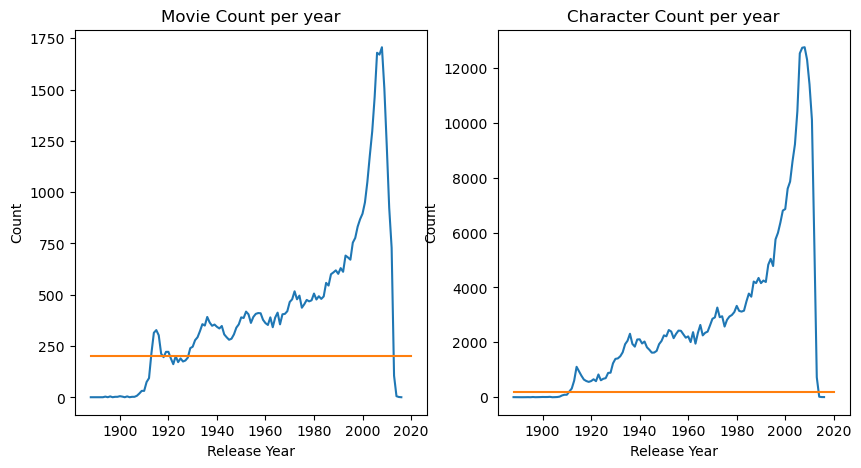

In [29]:
movie_geo_count_per_year = cmu_geo.groupby(['ReleaseYear']).agg({'WikiMovieID' : 'nunique'})
character_geo_count_per_year = cmu_geo.groupby(['ReleaseYear']).agg({'Gender': 'count'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize= (10,5))
ax1.plot(movie_geo_count_per_year)
ax1.plot([1888, 2020], [200, 200])
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Count')
ax1.set_title('Movie Count per year')

ax2.plot(character_geo_count_per_year)
ax2.plot([1888, 2020], [200, 200])
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Count')
ax2.set_title('Character Count per year')

plt.show()

In [30]:
# Keep only movies between 1930 and 2012 to have at least 200 movies per year and at least 100 characters per year
cmu_geo = cmu_geo.loc[(movies['ReleaseYear'] >= 1930) & (cmu_geo['ReleaseYear'] <= 2012)].copy(deep=True)
print(f'The cmu_geo dataset contains {len(cmu_geo.index)} entries after filtering to have at least 200 movies and 100 characters per year')

The cmu_geo dataset contains 67623 entries after filtering to have at least 200 movies and 100 characters per year


In [31]:
print('Percentage of missing entries in the cmu_geo dataset:\n', 100*cmu[['WikiMovieID', 'FreebaseMovieID', 'MovieName', 'ReleaseDate', 'BORevenue',
                                                                                 'ReleaseYear', 'CharacterName',
                                                                                  'Gender', 'Ethnicity',
                                                                                   'ActorName', 'Age', 'FreebaseCharacterID',
                                                                                   'FreebaseActorID', 'FreebaseActorMapID']].isna().sum() / len(cmu_geo))

print('Languages', percent_missing_strdict(cmu_geo['Languages'])) 
print('Countries', percent_missing_strdict(cmu_geo['Countries']))
print('MovieGenre', percent_missing_strdict(cmu_geo['MovieGenre']))   

Percentage of missing entries in the cmu_geo dataset:
 WikiMovieID             0.000000
FreebaseMovieID         0.000000
MovieName               0.000000
ReleaseDate             0.000000
BORevenue              76.942756
ReleaseYear             0.000000
CharacterName          54.340979
Gender                  0.000000
Ethnicity              74.891679
ActorName               0.007394
Age                    26.421484
FreebaseCharacterID    54.339500
FreebaseActorID         0.000000
FreebaseActorMapID      0.000000
dtype: float64
Languages 5.224553776082103
Countries 0.0
MovieGenre 0.8399509042781302


## PART 2: CoreNLP parsed movie summaries <a id="part2"></a>

We process the files contained in the corenlp_plot_summaries.tar archive.

All functions used for this part and other helpers are in the helpers_corenlp.py file.

In [ ]:
# First we extract the files contained in the tar file into .xml files
load_corenlp_data()

From the Bamman et al. paper [1], we know what type of dependencies we need to look for in the plot summary trees:
- for agent verbs: verbs for which the entity is
   - nsubj
   - agent
- for patient verbs: verbs for which the entity is
   - dobj
   - nsubjpass
   - iobj
   - any prepositional argument prep_*
- for attributes: adjectives and common noun words that relate to the mention as adjecti- val modifiers, noun-noun compounds, appos- itives, or copulas: 
   - nsubj or appos governors of a character mention
   - nsubj, appos, amod, nn dependents of a character mention

This search is directly implemented in a function.

The idea is also to count the number of mentions of each character of a movie and then use this number of mentions as a proxy for identifying the main character. Thus in our case we define the main character as the moset mentioned one in the plot summary.

In [ ]:
# get the Wikipedia movie id from the Lord of the Ring movies
test_ids = characters[characters['CharacterName'] == 'Aragorn']['WikiMovieID'].values

In [ ]:
# get the main character names from the Lord of the Ring movies
for id in test_ids:
    movie_xml = str(id) + '.xml'
    print(get_main_character(movie_xml))

As we expect, we extract Frodo as the main character of all the Lord of the Ring movies.
But we see that depending on the plot summary, the character's full name extracted can be different...

We thus need to check in a bidirectional way what the "fullest" name used is between the name extracted from the summary and the one used in the character metadata before merging.

In [ ]:
lst = []
# we only iterate over movies for which both character and movie metadata is available
ids = np.intersect1d(movies['WikiMovieID'].unique(), characters['WikiMovieID'].unique())
for id in ids[:100]:
    # We extract the data from the .xml files into a list of dictionaries
    if os.path.isfile(CORE_NLP_XML + '/' + str(id) + '.xml'):
        lst = lst + get_list_movie(str(id) + '.xml')
        cmu_characters = list(cmu[cmu['WikiMovieID'] == id].CharacterName)
        xml_characters = list(get_characters_from_xml(str(id) + '.xml'))
        characters = cmu_characters + xml_characters
        # type cast to string
        characters = [str(x) for x in characters]
        # get the full names of the characters
        dict = get_full_names_dict(characters)
        # replace cmu CharacterName by the full name in that movie
        cmu.loc[cmu['WikiMovieID'] == id, 'CharacterName'] = cmu.loc[cmu['WikiMovieID'] == id, 'CharacterName'].apply(lambda x: dict[x] if x in dict.keys() else x)

# We convert the list of dictionaries into a dataframe
df_corenlp = pd.DataFrame(lst)

df_corenlp.head()

The code takes a lot of time to run so for now we only do it for a few movies (for the first 100 IDs).

In [ ]:
print(type(cmu.WikiMovieID[0]))
print(type(df_corenlp.WikiMovieID[0]))

We need to typecast so that we can merge!

In [ ]:
# change the type of the WikiMovieID column to int64
df_corenlp['WikiMovieID'] = df_corenlp['WikiMovieID'].astype('int64')

In [ ]:
cmu_corenlp = cmu.merge(df_corenlp, how='inner', on=['WikiMovieID', 'CharacterName'])

In [ ]:
cmu_corenlp.head()

We get a dataframe with character information extracted from the movie plot summary joined with metadata from the CMU movie corpus. The information extracted from the CoreNLP parsed summaries will be used to cluster characters based on their depiction in the summary.

## PART 3: IMDB datasets <a id="part3"></a>

In [32]:
#Load the datasets
IMDB_title = pd.read_csv(IMDB_BASICS_PATH,sep='\t', low_memory=False)
IMDB_ratings = pd.read_csv(IMDB_RATINGS_PATH, sep = '\t')

In [33]:
display(IMDB_ratings)

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688
...,...,...,...
1366964,tt9916730,7.6,11
1366965,tt9916766,7.0,22
1366966,tt9916778,7.2,36
1366967,tt9916840,8.8,6


In [34]:
display(IMDB_title)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10295872,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10295873,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10295874,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10295875,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [35]:
# only choose the rows which correspond to data of a movie
IMDB_title = IMDB_title[IMDB_title['titleType'] == 'movie'].copy(deep=True)

#merge the dataset with the titles and the dataset with the ratings
df_IMDB = IMDB_title.merge(IMDB_ratings, left_on='tconst', right_on='tconst')
display(df_IMDB)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,484
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,855
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.0,21
...,...,...,...,...,...,...,...,...,...,...,...
299653,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84,Thriller,5.8,1448
299654,tt9916362,movie,Coven,Akelarre,0,2020,\N,92,"Drama,History",6.4,5605
299655,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,\N,"Adventure,History,War",3.5,17
299656,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123,Drama,8.6,7


Let's check if there are aberrant values in the averageRating column, for example negative values or values higher than 10.

In [36]:
df_IMDB.describe()

,averageRating,numVotes
count,299658.000000,2.996580e+05
mean,6.175995,3.619263e+03
std,1.370387,3.570741e+04
min,1.000000,5.000000e+00
25%,5.300000,1.900000e+01
50%,6.300000,6.100000e+01
75%,7.100000,3.130000e+02
max,10.000000,2.816055e+06


There are no aberrant values in the averageRating column.

### Calculate the average rating of each movie

We want to have the average rating of each movie. In df_IMDB, we have several ratings for each movies; indeed, the same movie (characterized by its 'orginialTitle') has a grade for each 'primaryTitle' used.
In the calculation of the average rating per originalTitle, we will ponderate the rating per primaryTitle with the number of votes per primaryTitle.
Then, we will calculate the average rating across all primaryTitle i for an originalTitle as :  
$Average\, Rating\, of\, originalTitle =\frac{\sum {average\,rating\,of\,primaryTitle(i) \times number\,of\,votes\,of\,primaryTitle(i)}} {\sum{number\,of\,votes\,of\,primaryTitle(i)}}$

In [37]:
#create datasets of average ratings of a movie considering the ratings of movies with titles in different language


#Calculate average_rating_language(i) * number_of_votes_language(i) (ponderate)
df_IMDB['mult_ratings'] = df_IMDB['averageRating']*df_IMDB['numVotes']

average_ratings = pd.DataFrame()
average_ratings['sum_of_mult_ratings'] = df_IMDB[['originalTitle', 'mult_ratings']].groupby('originalTitle').sum()
average_ratings['total_vote'] = df_IMDB[['originalTitle', 'numVotes']].groupby('originalTitle').sum()
average_ratings['total_average_rating'] = average_ratings['sum_of_mult_ratings']/average_ratings['total_vote']

average_ratings = average_ratings.reset_index(level=0)

#Create a new dataframe with the movies primary titles, release years, and average ratings.
ratings = df_IMDB.merge(average_ratings[['total_average_rating', 'originalTitle', 'total_vote']], how = 'left', on = 'originalTitle')
ratings=ratings[['primaryTitle', 'startYear', 'total_average_rating', 'total_vote']]
ratings=ratings.drop_duplicates(subset=['primaryTitle', 'startYear' ]).copy(deep=True)

#Prepare the dataset to be merged with CMU movies.
ratings= ratings.rename(columns = {"primaryTitle" : "MovieName", "startYear" : "ReleaseYear", "total_average_rating" : "AverageRating", "total_vote" : "NumberofVotes"})
ratings["ReleaseYear"]=pd.to_datetime(ratings["ReleaseYear"], errors='coerce').dt.year

display(ratings)

,MovieName,ReleaseYear,AverageRating,NumberofVotes
0,Miss Jerry,1894.0,5.300000,207
1,The Corbett-Fitzsimmons Fight,1897.0,5.300000,484
2,Bohemios,1905.0,4.285714,28
3,The Story of the Kelly Gang,1906.0,6.000000,855
4,The Prodigal Son,1907.0,5.036364,33
...,...,...,...,...
299652,Safeguard,2020.0,3.700000,245
299653,Il talento del calabrone,2020.0,5.800000,1448
299655,The Secret of China,2019.0,3.500000,17
299656,Kuambil Lagi Hatiku,2019.0,8.600000,7


### Merge with the CMU movies dataset

We populate our movies dataset with the available movie ratings. 

In [38]:
ratings = cmu.merge(ratings, on=["MovieName", "ReleaseYear"], how='left' ).copy(deep=True)
display(ratings)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,AverageRating,NumberofVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0,Akooshay,F,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,56894.0
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0,Lieutenant Melanie Ballard,F,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,56894.0
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0,Desolation Williams,M,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,56894.0
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0,Sgt Jericho Butler,M,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,56894.0
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001.0,Bashira Kincaid,F,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,56894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68553,35061219,/m/0h2jw2t,Payback Season,2012-03-09,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'},2012.0,Andy,M,NaN,Leo Gregory,33.0,/m/0h9757y,/m/0h97kj1,/m/04ghm8g,3.7,649.0
68554,35061219,/m/0h2jw2t,Payback Season,2012-03-09,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'},2012.0,Lisa,F,NaN,Nichola Burley,25.0,/m/0h9759t,/m/0h97kj9,/m/0404916,3.7,649.0
68555,35061219,/m/0h2jw2t,Payback Season,2012-03-09,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'},2012.0,Katie,F,NaN,Stephanie Siadatan,NaN,/m/0h97593,/m/0h97kh1,/m/0h97596,3.7,649.0
68556,35061219,/m/0h2jw2t,Payback Season,2012-03-09,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'},2012.0,Brooksy,M,NaN,Bronson Webb,29.0,/m/0h9759g,/m/0h97kk9,/m/0bb9qzp,3.7,649.0


In [39]:
print('Percentage of missing entries in the ratings dataset:\n', 100*ratings[['AverageRating', 'NumberofVotes']].isna().sum() / len(ratings))

Percentage of missing entries in the ratings dataset:
 AverageRating    34.184194
NumberofVotes    34.184194
dtype: float64


## PART 4: Oscars datasets <a id="part4"></a>

In [49]:
awards = pd.read_csv(AWARDS_PATH, names = ['ReleaseYear','CeremonyYear' ,'Ceremony','Category','NomineeName',
                                                                      'MovieName','Winner'], skiprows=1)

display(awards)

,ReleaseYear,CeremonyYear,Ceremony,Category,NomineeName,MovieName,Winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10760,2022,2023,95,HONORARY AWARD,"To Euzhan Palcy, a masterful filmmaker who bro...",NaN,True
10761,2022,2023,95,HONORARY AWARD,"To Diane Warren, for her genius, generosity an...",NaN,True
10762,2022,2023,95,HONORARY AWARD,"To Peter Weir, a fearless and consummate filmm...",NaN,True
10763,2022,2023,95,GORDON E. SAWYER AWARD,Iain Neil,NaN,True


In [50]:
print('Percentage of missing entries in the awards dataset:\n', 100*awards[['ReleaseYear', 'CeremonyYear', 'Ceremony', 'Category', 'NomineeName', 'MovieName', 'Winner']].isna().sum() / len(awards))

Percentage of missing entries in the awards dataset:
 ReleaseYear     0.000000
CeremonyYear    0.000000
Ceremony        0.000000
Category        0.000000
NomineeName     0.037157
MovieName       2.926150
Winner          0.000000
dtype: float64


We remove lines where we lack the nominee name and movie name

In [51]:
awards = awards.drop(awards[awards['MovieName'].isnull()].index).copy(deep=True)
awards = awards.drop(awards[awards['NomineeName'].isnull()].index).copy(deep=True)

print(f'After filtering, we are left with {len(awards.index)} entries')

After filtering, we are left with 10450 entries


In [54]:
common_films = len(set(awards['MovieName']) & set(cmu['MovieName']))
print('Percentage of common films between the awards and CMU movies compared to total CMU: ', 100*common_films/len(cmu['MovieName']))
print('Percentage of common films between the awards and CMU movies compared to total awards: ',100*common_films/len(awards['MovieName']))

Percentage of common films between the awards and CMU movies compared to total CMU:  1.0822952828262202
Percentage of common films between the awards and CMU movies compared to total awards:  7.100478468899522


## PART 5: Bechdel dataset <a id="part4"></a>

In [55]:
# Load bechdel data
bechdel = pd.read_csv(BECHDEL_PATH, sep='\t', names=['MovieName', 'ReleaseYear', 'BechdelScore', 'Dubious', 'IMDB_ID','ID', 'SubmitterID', 'R'] )
display(bechdel)

,title,year,rating,dubious,imdbid,id,submitterid,date,visible
0,Passage de Venus,1874,0,0.0,3155794,9602,18880,2021-04-02 20:58,1
1,La Rosace Magique,1877,0,0.0,14495706,9804,19145,2021-05-11 0:11,1
2,Sallie Gardner at a Gallop,1878,0,0.0,2221420,9603,18882,2021-04-03 2:25,1
3,Le singe musicien,1878,0,0.0,12592084,9806,19151,2021-05-11 23:38,1
4,Athlete Swinging a Pick,1881,0,0.0,7816420,9816,19162,2021-05-13 1:32,1
...,...,...,...,...,...,...,...,...,...
9897,Spider-Man: No Way Home,2021,3,1.0,10872600,10166,19768,2021-12-21 02:14:30,1
9898,Timeless,2018,3,0.0,5511582,10165,19766,2021-12-21 00:49:07,1
9899,Red Notice,2021,1,0.0,7991608,10164,19765,2021-12-20 14:10:11,1
9900,Abbott and Costello Meet Frankenstein,1948,3,0.0,40068,10163,19764,2021-12-19 18:11:42,1


In [56]:
bechdel.describe()

,year,rating,dubious,imdbid,id,submitterid,visible
count,9902.000000,9902.000000,9603.000000,9.902000e+03,9902.000000,9902.000000,9902.0
mean,1996.405171,2.133205,0.090909,2.342054e+06,5283.208645,9801.553828,1.0
std,25.110394,1.100234,0.287495,6.164546e+07,3088.966247,6462.398855,0.0
min,1874.000000,0.000000,0.000000,1.000000e+00,1.000000,1.000000,1.0
25%,1988.000000,1.000000,0.000000,9.977825e+04,2583.250000,3865.500000,1.0
50%,2006.000000,3.000000,0.000000,4.382925e+05,5265.500000,9626.500000,1.0
75%,2013.000000,3.000000,0.000000,2.035422e+06,7891.500000,15388.500000,1.0
max,2023.000000,3.000000,1.000000,6.129999e+09,10785.000000,20969.000000,1.0


In [57]:
print('Percentage of missing entries in the bechdel dataset:\n', 100*bechdel[['year', 'rating', 'dubious', 'imdbid', 'id', 'submitterid', 'visible']].isna().sum() / len(bechdel))

KeyError: "None of [Index([''], dtype='object')] are in the [columns]"

In case we want to merge the bechdel and the cmu datasets, we need to format the movie names the same way. We choose to rewrite every movie name in lower case.

In [ ]:
# Put all title in lower case
bechdel['title'] = df_bechdel['title'].apply(lambda x: x.lower())
cmu_bechdel = cmu.copy(deep=True)
cmu_bechdel['MovieName'] = cmu_bechdel['MovieName'].apply(lambda x: x.lower())

#We populate the cmu dataset with availables Bechdel


# STEP 2: DATA ANALYSIS <a id="Data-analysis"></a>

---

## PART 1: Quantitative analysis of gender inequalities in movies <a id="part1"></a>

We will start by analysing the main differences we can find between the representation of men and women in the movie industry.

### AGE: IS THERE A DIFFERENCE ?

We often hear clichés about the evolution of beauty with age: women are described as blossoming in their youth, while men become more handsome with age. An intriguing question arises: does this perceived divergence in the aesthetics of aging manifest itself in the film industry, and if so, is this disparity statistically significant? 

Let's explore the data !

In [ ]:
# Set the plot style and color palette
sns.set(style="darkgrid", palette="Set2")

plt.figure(figsize=(8, 5))

sns.boxplot(x='Gender', y='Age', data=cmu)
plt.title('Distribution of Age between Male and Female', fontsize=15)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

In [ ]:
women_cmu = cmu.loc[cmu['Gender']=='F'].copy(deep=True)
men_cmu = cmu.loc[cmu['Gender']=='M'].copy(deep=True)

In [ ]:
women_cmu.sample(2)

In [ ]:
# T-test to determine if the difference in age between men and women is statistically significant 
stats.ttest_ind(women_cmu['Age'], men_cmu['Age'], nan_policy='omit')

We used a two-sided t-test for the null hypothesis that the age of actors and actresses have identical average (expected) values. The p-value is much smaller than 0.05, therefore we can reject the null hypothesis, meaning that there is a statistically significant difference in the average ages between the two groups. As the t-statistic is strongly negative (-104), it supports our conclusion that women are significantly younger than men.

### Has this tendency evolved with years ?

In [ ]:
# Calculate the average age of actors and actresses in movies across year
women_mean_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})
men_mean_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})

# Calculate the 95% CIs
women_std_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'std'})
men_std_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'std'})

z=1.96
upper_bound_women = women_mean_age_per_year['Age'] + z*women_std_age_per_year['Age']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])
lower_bound_women = women_mean_age_per_year['Age'] - z*women_std_age_per_year['Age']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])

upper_bound_men = men_mean_age_per_year['Age'] + z*men_std_age_per_year['Age']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])
lower_bound_men = men_mean_age_per_year['Age'] - z*men_std_age_per_year['Age']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])

# Plot the evolution of mean age of men and women in movies
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(women_mean_age_per_year, label='F', color='green')
ax.fill_between(women_mean_age_per_year.index, lower_bound_women, upper_bound_women, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(men_mean_age_per_year, label='M', color='red')
ax.fill_between(men_mean_age_per_year.index, lower_bound_men, upper_bound_men, alpha =0.2, color='red', label = 'M 95% CI')

ax.set_ylim(10,47)
ax.set_xlabel('Year')
ax.set_ylabel('Age')
ax.set_title('Evolution of mean age of men and women in movies')
ax.legend()

plt.show()

### PROPORTION OF FEMALE CHARACTERS

We will explore the proportion of female characters in movies.

In [ ]:
df_gender_proportion_by_movie=pd.DataFrame()

df_gender_proportion_by_movie['MaleCharacters'] = men_cmu.groupby('WikiMovieID')['CharacterName'].nunique()
df_gender_proportion_by_movie['FemaleCharacters'] = women_cmu.groupby('WikiMovieID')['CharacterName'].nunique()

df_gender_proportion_by_movie['TotalNumberofCharacters'] = cmu.groupby('WikiMovieID')['CharacterName'].nunique()

df_gender_proportion_by_movie = df_gender_proportion_by_movie.merge(cmu[['ReleaseYear', 'WikiMovieID', 'Countries', 'Continent']], how='left', left_index=True, right_on='WikiMovieID' )

df_gender_proportion_by_movie['PercentageofFemale'] = df_gender_proportion_by_movie['FemaleCharacters'] / df_gender_proportion_by_movie['TotalNumberofCharacters'] * 100
df_gender_proportion_by_movie['PercentageofMale'] = df_gender_proportion_by_movie['MaleCharacters'] / df_gender_proportion_by_movie['TotalNumberofCharacters'] * 100

df_gender_proportion_by_movie =df_gender_proportion_by_movie.drop_duplicates(subset=['WikiMovieID'])

#Plot
fig, ax = plt.subplots(1, 3, figsize=(16,8), sharey=True)

ax[0].hist(df_gender_proportion_by_movie['PercentageofFemale'], bins=50, label='F', alpha=0.4, color='green')
ax[0].hist(df_gender_proportion_by_movie['PercentageofMale'], bins=50, label='M', alpha=0.4, color='red')
ax[0].legend(loc='upper right', fontsize=14) 

ax[1].hist(df_gender_proportion_by_movie['PercentageofFemale'], bins=50, label='F', alpha=0.5, color='green')
ax[1].legend(loc='upper right', fontsize=14) 


ax[2].hist(df_gender_proportion_by_movie['PercentageofMale'], bins=50, label='M', alpha=0.5, color='red')
ax[2].legend(loc='upper right', fontsize=14) 

fig.supxlabel('Percentage of characters per movie', fontsize=16)
fig.supylabel('Counts', va='center', rotation=90, fontsize=16)
fig.suptitle('Histograms of the percentage of Female and Male characters per movie', fontsize=20)

plt.tight_layout()

plt.show()

In [ ]:
#Calculate the mean percentage of actors and actresses in movies across year
percentage_of_women_by_movie = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofFemale':'mean'})
percentage_of_men_by_movie = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofMale':'mean'})

#Calculate the 95% CIs
women_std_perc_per_year = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofFemale':'std'})
men_std_perc_per_year = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofMale':'std'})

z=1.96
upper_bound_women = percentage_of_women_by_movie['PercentageofFemale'] + z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_women = percentage_of_women_by_movie['PercentageofFemale'] - z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])

upper_bound_men = percentage_of_men_by_movie['PercentageofMale'] + z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_men = percentage_of_men_by_movie['PercentageofMale'] - z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])

#Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(percentage_of_women_by_movie, label='F', color='green')
ax.fill_between(lower_bound_women.index, lower_bound_women, upper_bound_women, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(percentage_of_men_by_movie, label='M', color='red')
ax.fill_between(lower_bound_men.index, lower_bound_men, upper_bound_men, alpha =0.2, color='red', label = 'M 95% CI')

#ax.set_ylim(0,101)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Evolution of mean percentage of male and female characters in movies')
ax.legend()
plt.show()

### GENRE OF MOVIE: IS THERE A DIFFERENCE ?

An often-repeated stereotype regarding women suggests that they are not inclined towards action, sports, or intellectual pursuits, but rather, their primary role is portrayed as being centered around romantic relationships. We aim to investigate whether this stereotype is reflected in the portrayal of women in movies from our dataset.

We will do our analysis only based on the 16 major genres of movie in the dataset. First, we need to determine what these 16 genres are.

In [ ]:
# Filter the cmu dataset to get only 1 row per movie. Otherwise, the genres are counted too many times
cmu_without_duplicates = cmu.drop_duplicates(subset=['WikiMovieID'], keep='first')

In [ ]:
all_unique_genres = set()

# Get all the movie genres
cmu_without_duplicates['MovieGenre'].apply(lambda x: all_unique_genres.update(x.values()) if isinstance(x, dict) else None)

# Initialize dictionary with keys and values set to 0
genres_count = {genre: 0 for genre in all_unique_genres}

# Count the occurence of each genre
for row in cmu_without_duplicates['MovieGenre']:
    for key, value in row.items():
        genres_count[value]+=1
        
# Sort the dictionary by values in descending order
genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))

In [ ]:
plt.figure(figsize=(8, 4))

# Keep the first 16 major genres
major_16_genres = dict(islice(genres_count.items(), 16))

x = np.arange(len(major_16_genres))

plt.bar(x, major_16_genres.values())
plt.xticks(x, major_16_genres.keys(), rotation='vertical')
plt.title('16 Major Genres of Movies', fontsize=16)
plt.ylabel('Number of movie for each genre')
plt.show()

For the analysis we consider that:
- If a movie has several genres, we will keep the one that appears in the 16 major genres, and if several are in the 16 major genres, we keep the first one.
- If none is in the 16 major genre, or if the genre is not given, then we drop the row

In [ ]:
# List of rows to drop 
rows_to_drop = []

cmu_genre = cmu.copy()

for index, row in cmu_genre.iterrows():
    movie_genre = row['MovieGenre']
    
    # If there is one genre only, drop the row if not in the 16 major genre
    if len(movie_genre) == 1 and list(movie_genre.values())[0] not in major_16_genres:
        rows_to_drop.append(index)
        
    # If there is no genre, drop the corresponding row
    elif not bool(movie_genre):
        rows_to_drop.append(index)
            
    # If there are multiple genres        
    else:
        count = 0  # To keep the first value only
        for key, value in movie_genre.items():
            if value in major_16_genres:
                if count == 0:
                    value_to_keep = value
                    key_to_keep = key
                    count = 1
                    break

        if count == 0:  # If none of the genres is in the major_16_genres, drop the row
            rows_to_drop.append(index)

        if count == 1:
            cmu_genre.at[index, 'MovieGenre'] = {key_to_keep: value_to_keep}

# Create a new DataFrame with only the rows to keep
cmu_genre = cmu_genre.drop(rows_to_drop)
movie_counts = cmu_genre['WikiMovieID'].nunique()
print(f'We are left with {movie_counts} movies')

To facilitate analysis, we replace the dictionary for the 'MovieGenre' column with a str:

In [ ]:
cmu_genre['MovieGenre'] = cmu_genre['MovieGenre'].apply(lambda x: list(x.values())[0])

In [ ]:
# Split the dataset in 2 according to actor gender
women_with_genre = cmu_genre.loc[cmu_genre['Gender']=='F'].copy(deep=True)
men_with_genre = cmu_genre.loc[cmu_genre['Gender']=='M'].copy(deep=True)

In [ ]:
# Group by 'MovieGenre' and count the number of occurence
women_genre_counts = women_with_genre.groupby('MovieGenre').size().reset_index(name='Women_Count')
men_genre_counts = men_with_genre.groupby('MovieGenre').size().reset_index(name='Men_Count')

# New dataframe with the counts
genre_counts = women_genre_counts.merge(men_genre_counts, how='left', on='MovieGenre')

# Compute the percentage of Women and Men per movie genre
genre_counts['Percent_Women']=(genre_counts['Women_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100
genre_counts['Percent_Men']=(genre_counts['Men_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100

In [ ]:
genre_counts.sample(2)

In [ ]:
# Plot the percentage of Women and Men per movie genre

# Sort the DataFrame for better visualization
genre_counts = genre_counts.sort_values(by='Percent_Men', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(genre_counts['MovieGenre'], genre_counts['Percent_Men'], label='Men', alpha=0.9)
ax.bar(genre_counts['MovieGenre'], genre_counts['Percent_Women'], bottom=genre_counts['Percent_Men'], label='Women', alpha=0.9)

plt.xticks(rotation='vertical')
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Women and Men by Movie Genre')
ax.legend()

plt.show()

Is there a difference in actors' ages between genres? 

In [ ]:
cmu_by_genre = cmu_genre.groupby('MovieGenre')

fig, axes = plt.subplots(4,4,figsize= (16,16), sharey=True)

for genre, ax in zip(cmu_by_genre.groups.keys(), axes.flat):
    sns.set(style="darkgrid", palette="Set2")
    
    plot = sns.barplot(x='Gender', y='Age', data=cmu_by_genre.get_group(genre), ax=ax, order=['M', 'F'], errorbar=('ci',95))
    plot.set_title(genre)
    plot.set(ylabel=None)
    plot.set(xlabel=None)
    plot.set(ylim = (0,44))

fig.supxlabel('Gender', fontsize=20)
fig.supylabel('Mean Age', va='center', rotation=90, fontsize=20)
fig.suptitle('Difference in mean age between actor and actress per genre of movie', fontsize=24)

plt.tight_layout()

plt.show()

Across all genres we observe a similar inequality in the average age of actors and actresses. Actresses are generally younger in all movie genres and the difference is significant when looking at the small 95 % confidence intervals

### What is the typical carrier of men and women ?

In [ ]:
movies_per_actress = women_cmu.groupby('ActorName').size().reset_index(name='number_of_movies')
movies_per_actor = men_cmu.groupby('ActorName').size().reset_index(name='number_of_movies')

In [ ]:
# Combine the two DataFrames into a single DataFrame
movies_per_actor_and_actress = pd.concat([movies_per_actress.assign(gender='F'), 
                                          movies_per_actor.assign(gender='M')])

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='number_of_movies', data=movies_per_actor_and_actress, showfliers=False)
plt.xlabel('Gender')
plt.ylabel('Number of Movies')
plt.title('Comparison of Number of Movies for Actors and Actresses')
plt.show()

## PART 2: Qualitative analysis of gender representation in movies <a id="part2"></a>

### What are the types of characters women interpret ? 

Let's uncover whether the common stereotypes about women align with the characters we observe on the screen.


For this analysis, we will use the tvtropes.clusters file

In [ ]:
with open(CHARACTER_TYPE_PATH, 'r') as file:
    lines = file.readlines()
    new_lines = []
    
    for line in lines:
        char_type = line.split()[0]
        char_type_dict = {'CharType': char_type}

        space_index = line.find('	')
        char_info = ast.literal_eval(line[space_index+1:])
        
        new_line = {**char_type_dict, **char_info}
        
        new_lines.append(new_line)
    

# Evaluate each line and extract the column name and corresponding dictionary

headers_names = ['CharType',
                 'CharName',
                 'MovieName',
                 'FreebaseActorMapID',
                 'ActorName']

chartypes = pd.DataFrame(new_lines)
chartypes.columns = headers_names
chartypes.head()

In [ ]:
chartype_cmu = cmu.merge(chartypes, how='right', on=['FreebaseActorMapID', 'MovieName'])
chartype_women = chartype_cmu.loc[chartype_cmu['Gender']=='F'].copy(deep=True)
chartype_men = chartype_cmu.loc[chartype_cmu['Gender']=='M'].copy(deep=True)

In [ ]:
women_counts = chartype_women['CharType'].value_counts().head(5)
men_counts = chartype_men['CharType'].value_counts().head(5)

In [ ]:
# Create WordClouds for women and men
women_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(women_counts)
men_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(men_counts)

# Plotting the WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(women_wordcloud, interpolation='bilinear')
plt.title('Women Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(men_wordcloud, interpolation='bilinear')
plt.title('Men Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.show()

## PART 3: Analysis of the reception of movies by the public <a id="part3"></a>

### Is there a difference in revenue and popularity between female-dominated and male-dominated films?

We want to analyse whether the success of a movie is correlated with the proportion of women in a movie. To to this we will take the Box Office Revenue as a measure of success, as well as the IMDb ratings given around the world to each movie.

### Looking at the ratings

In [ ]:
# IMDb data set merged with the CMU movies
ratings = pd.read_csv(RATINGS_PATH, sep='\t',)
ratings.sample(2)

In [ ]:
# We're interested only in movies for which we have information on gender distribution, so we perform a right join
ratings_gender = pd.merge(ratings, df_gender_proportion_by_movie, on='WikiMovieID', how='right')

# Sort the values according to Percentage of Female 
ratings_gender.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=ratings_gender['PercentageofFemale'], y=ratings_gender['AverageRating'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.ylabel('Average IMDb Rating')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between IMDb Average Rating and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the rating given on IMDb. This shows us that there is a slight negative correlation, meaning that movies with a higher percentage of women tend to have a slightly worse rating. We need to check this with other statistical metrics. 

### Looking at the Box office revenue

Aside from how a movie has been rated on IMDb, it is also interesting to look at its comercial success. This gives another insight on how the movie was globally percieved and if it impacted a lot of people or not. Therefore we are now looking at the boxoffice revenue of movies where we have the information from the original CMU data set. 

In [ ]:
# Remove movies where we don't have the Box Office Revenue.
BO_ratings = ratings_gender.dropna(subset = 'BORevenue')

# Sort the values according to Percentage of Female 
BO_ratings.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=BO_ratings['PercentageofFemale'], y=BO_ratings['BORevenue'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.yscale("log")
plt.ylabel('Box Office Revenue')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between Box Office Revenue and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the Box Office Revenue. This shows us that there is a negative correlation, meaning that movies with a higher percentage of women tend to have a lower Box Office Revenue. We need to check this with other statistical metrics. 

## PART 4: Analysis by geographical production region <a class="anchor" id="part4"></a>

### Do we have enough movies per continent ?

In [ ]:
# Keep only 1 row per movie to count the number of movies per continent
cmu_countries_filtered = cmu.drop_duplicates(subset=['MovieName', 'ReleaseYear', 'Continent'])
counts_per_continent = cmu_countries_filtered.groupby('Continent').size()

In [ ]:
plt.figure(figsize=(8, 4))
counts_per_continent.plot(kind='bar')

plt.xlabel('Continents')
plt.ylabel('Number of movies')
plt.title('Number of movies per continent')

plt.show()

### Gender proportion split by geographical area

In [ ]:
cmu_countries_filtered.sample(2)

In [ ]:
# convert list in string
cmu_countries['Countries'] = cmu_countries['Countries'].apply(lambda x: x[0] if isinstance(x, list) else x)
cmu_countries.sample(2)

In [ ]:
# Proportion of gender in USA
df_gender_proportion_by_movie_us = df_gender_proportion_by_movie[df_gender_proportion_by_movie['Countries'] == 'US']
df_gender_proportion_by_movie_us.sample(2)


In [ ]:
# Proportion of gender in Europe
df_gender_proportion_by_movie_europe = df_gender_proportion_by_movie[df_gender_proportion_by_movie['Continent'] == 'EU']
df_gender_proportion_by_movie_europe.sample(2)

In [ ]:
# Proportion of gender in India
df_gender_proportion_by_movie_india = df_gender_proportion_by_movie[df_gender_proportion_by_movie['Countries'] == 'IN']
df_gender_proportion_by_movie_india.sample(2)

In [ ]:
#Calculate the mean percentage of actors and actresses in movies across year in US
percentage_of_women_by_movie = df_gender_proportion_by_movie.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'PercentageofFemale':'mean'})
percentage_of_men_by_movie = df_gender_proportion_by_movie.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'PercentageofMale':'mean'})

#Calculate the 95% CIs
women_std_perc_per_year = df_gender_proportion_by_movie.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'PercentageofFemale':'std'})
men_std_perc_per_year = df_gender_proportion_by_movie.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'PercentageofMale':'std'})

z=1.96
upper_bound_women = percentage_of_women_by_movie['PercentageofFemale'] + z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_women = percentage_of_women_by_movie['PercentageofFemale'] - z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'CharacterName': 'count'})['CharacterName'])

upper_bound_men = percentage_of_men_by_movie['PercentageofMale'] + z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_men = percentage_of_men_by_movie['PercentageofMale'] - z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'CharacterName': 'count'})['CharacterName'])


In [ ]:
# Plot gender distribution for US, Europe and India
percentage_of_women_by_movie_us = percentage_of_women_by_movie[percentage_of_women_by_movie.index.get_level_values('Countries') == 'US']
lower_bound_women_us = lower_bound_women[lower_bound_women.index.get_level_values('Countries') == 'US']
upper_bound_women_us = upper_bound_women[upper_bound_women.index.get_level_values('Countries') == 'US']
percentage_of_men_by_movie_us = percentage_of_men_by_movie[percentage_of_men_by_movie.index.get_level_values('Countries') == 'US']
lower_bound_men_us = lower_bound_men[lower_bound_men.index.get_level_values('Countries') == 'US']
upper_bound_men_us = upper_bound_men[upper_bound_men.index.get_level_values('Countries') == 'US']

percentage_of_women_by_movie_eu = percentage_of_women_by_movie[percentage_of_women_by_movie.index.get_level_values('Continent') == 'EU']
lower_bound_women_eu = lower_bound_women[lower_bound_women.index.get_level_values('Continent') == 'EU']
upper_bound_women_eu = upper_bound_women[upper_bound_women.index.get_level_values('Continent') == 'EU']
percentage_of_men_by_movie_eu = percentage_of_men_by_movie[percentage_of_men_by_movie.index.get_level_values('Continent') == 'EU']
lower_bound_men_eu = lower_bound_men[lower_bound_men.index.get_level_values('Continent') == 'EU']
upper_bound_men_eu = upper_bound_men[upper_bound_men.index.get_level_values('Continent') == 'EU']

percentage_of_women_by_movie_in = percentage_of_women_by_movie[percentage_of_women_by_movie.index.get_level_values('Countries') == 'IN']
lower_bound_women_in = lower_bound_women[lower_bound_women.index.get_level_values('Countries') == 'IN']
upper_bound_women_in = upper_bound_women[upper_bound_women.index.get_level_values('Countries') == 'IN']
percentage_of_men_by_movie_in = percentage_of_men_by_movie[percentage_of_men_by_movie.index.get_level_values('Countries') == 'IN']
lower_bound_men_in = lower_bound_men[lower_bound_men.index.get_level_values('Countries') == 'IN']
upper_bound_men_in = upper_bound_men[upper_bound_men.index.get_level_values('Countries') == 'IN']

fig, ax = plt.subplots(1, 3, figsize=(14,4))

ax[0].plot(percentage_of_women_by_movie_us.index.get_level_values('ReleaseYear'), percentage_of_women_by_movie_us['PercentageofFemale'], label='F', color='green')
#ax[0].fill_between(lower_bound_women_us.index, lower_bound_women_us, upper_bound_women_us, alpha =0.2, color='green', label = 'F 95% CI')
ax[0].plot(percentage_of_men_by_movie_us.index.get_level_values('ReleaseYear'), percentage_of_men_by_movie_us['PercentageofMale'], label='M', color='red')
#ax[0].fill_between(lower_bound_men_us.index, lower_bound_men_us, upper_bound_men_us, alpha =0.2, color='red', label = 'M 95% CI')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Gender distribution in movies in US')
ax[0].legend()

ax[1].plot(percentage_of_women_by_movie_eu.index.get_level_values('ReleaseYear'), percentage_of_women_by_movie_eu['PercentageofFemale'], label='F', color='green')
#ax[1].fill_between(lower_bound_women_us.index, lower_bound_women_us, upper_bound_women_us, alpha =0.2, color='green', label = 'F 95% CI')
ax[1].plot(percentage_of_men_by_movie_eu.index.get_level_values('ReleaseYear'), percentage_of_men_by_movie_eu['PercentageofMale'], label='M', color='red')
#ax[1].fill_between(lower_bound_men_us.index, lower_bound_men_us, upper_bound_men_us, alpha =0.2, color='red', label = 'M 95% CI')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Percentage')
ax[1].set_title('Gender distribution in movies in Europe')
ax[1].legend()

ax[2].plot(percentage_of_women_by_movie_in.index.get_level_values('ReleaseYear'), percentage_of_women_by_movie_in['PercentageofFemale'], label='F', color='green')
#ax[2].fill_between(lower_bound_women_us.index, lower_bound_women_us, upper_bound_women_us, alpha =0.2, color='green', label = 'F 95% CI')
ax[2].plot(percentage_of_men_by_movie_in.index.get_level_values('ReleaseYear'), percentage_of_men_by_movie_in['PercentageofMale'], label='M', color='red')
#ax[2].fill_between(lower_bound_men_us.index, lower_bound_men_us, upper_bound_men_us, alpha =0.2, color='red', label = 'M 95% CI')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Percentage')
ax[2].set_title('Gender distribution in movies in Europe')
ax[2].legend()